In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from distfit import distfit
import re
from sympy import symbols, simplify, sin, cos, log, Abs, exp, expand_power_base, Mul, Rational, sqrt
from sympy.parsing.sympy_parser import parse_expr
import seaborn as sns
import copy
import json
from ydata_profiling import ProfileReport
import sys
import os

# Add the directory containing 'thesis_utils.py' to the system path
sys.path.append(os.path.abspath('..'))  # If 'thesis_utils.py' is one level up
# Or use this if it's in the same directory as the notebook:
# sys.path.append(os.getcwd())

from thesis_utils import *

Detected IPython. Loading juliacall extension. See https://juliapy.github.io/PythonCall.jl/stable/compat/#IPython


In [2]:
import bnlearn as bn

In [31]:
import importlib
import thesis_utils  # or whatever your module is called

importlib.reload(thesis_utils)

from thesis_utils import *

In [3]:
df = pd.read_excel("C:/Users/svenl/vs_code_projects/hyperRealDataDescriber/data/real_estate/real_estate_valuation.xlsx")
df = df.rename(columns={"X2 house age": "X1 house age", 
                        "X3 distance to the nearest MRT station": "X2 distance MRT station", 
                        "X4 number of convenience stores": "X3 number convenience stores", 
                        "X5 latitude": "X4 lat", 
                        "X6 longitude": "X5 long", 
                        "Y house price of unit area": "X6 price"})
df = df[["X1 house age", "X2 distance MRT station", "X3 number convenience stores", "X4 lat", "X5 long", "X6 price"]]
df, rename_map = anonymize_column_names(df)

In [4]:
# Generate the profiling report
profile = ProfileReport(df[["X1", "X2", "X3", "X4", "X5"]], title="Real Estate Valuation Cleaned - Excl X6 price", explorative=True)

# Get the description object
desc = profile.get_description()

# Access the correlation matrix
correlation_matrix = desc.correlations["auto"]

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

In [44]:
expression_str_raw = "sqrt(x1) + (111.49027 - (log(x0 - -163.37123) * 11.177385))"
# expression_str_raw = "((sqrt(sqrt(x0)) * -6.824128) - ((cos((x0 + 4.1052847) / 0.11551076) + (sin(sqrt(x0) + cos((x1 / 0.115510926) + 73.136475)) - cos((x0 * 0.4697815) - sin(x0 / -0.041550487)))) * (cos(x1) + 3.7112134))) + 73.136475"
num_independent_vars = 2

def generate_var_string(num_independent_vars):
    var_string = ''
    for i in range(num_independent_vars):
        var_string = var_string + ('x' + str(i) + ' ')
    return var_string[0:len(var_string) - 1]

variables = generate_var_string(2)

exec(f"{', '.join(variables.split())} = symbols('{variables}')")

parsed_expr = parse_expr(expression_str_raw)
expr = simplify(parsed_expr)
print(expr)

sqrt(x1) - 11.177385*log(x0 + 163.37123) + 111.49027


In [42]:
# define variables to use in expression
x0_ = df['X2'].to_numpy()
x1_ = df['X3'].to_numpy()

price_predicted = -6.824128*x0_**(1/4) - (np.cos(x1_) + 3.7112134)*(np.sin(np.sqrt(x0_) + np.cos(8.65718971034827*x1_ + 73.136475)) - np.cos(0.4697815*x0_ + np.sin(24.067106602144*x0_)) + np.cos(8.65720215155714*x0_ + 35.5402795375946)) + 73.136475

In [45]:
# define variables to use in expression
x0_ = df['X2'].to_numpy()
x1_ = df['X3'].to_numpy()

price_predicted = np.sqrt(x1_) - 11.177385*np.log(x0_ + 163.37123) + 111.49027

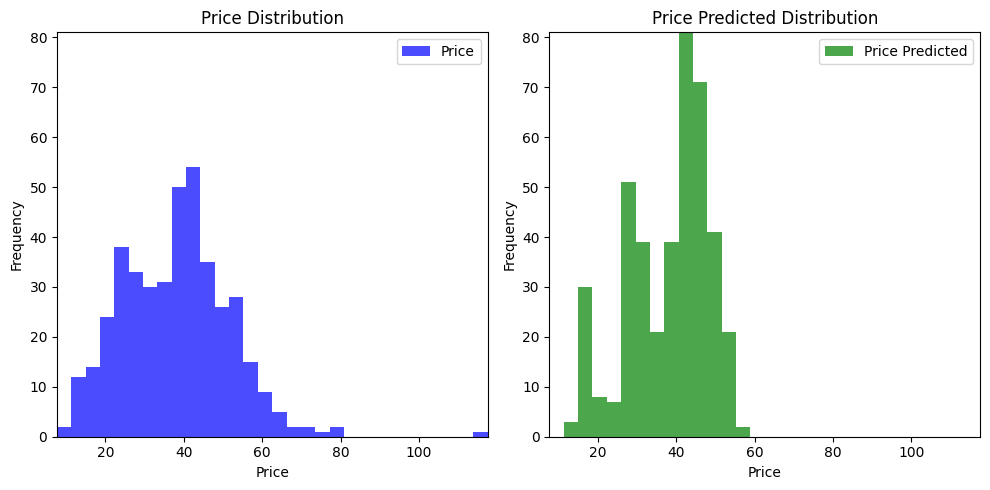

In [46]:
%matplotlib inline
plot_histograms([(df["X6"], "Price", "blue"), (price_predicted, "Price Predicted", "green")], xlabel="Price")

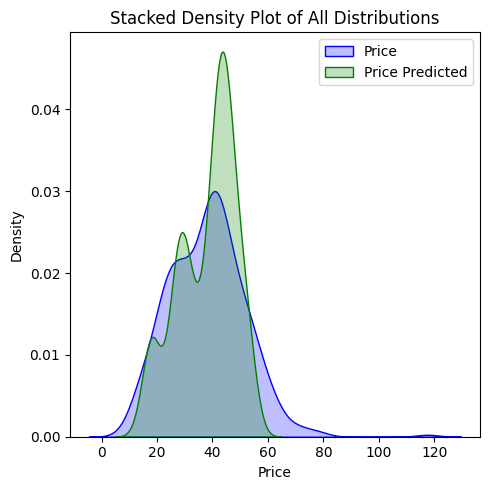

In [8]:
%matplotlib inline
plot_densities([(df["X6"], "Price", "blue"), (price_predicted, "Price Predicted", "green")], xlabel="Price", stack=True)

In [9]:
corrected_price = correct_sr_inference(df, ["X2", "X3"], "X6", pd.Series(price_predicted))

XGBoost Residual Correction Test MSE: 53.4094
Final MSE after XGBoost residual correction: 16.3442


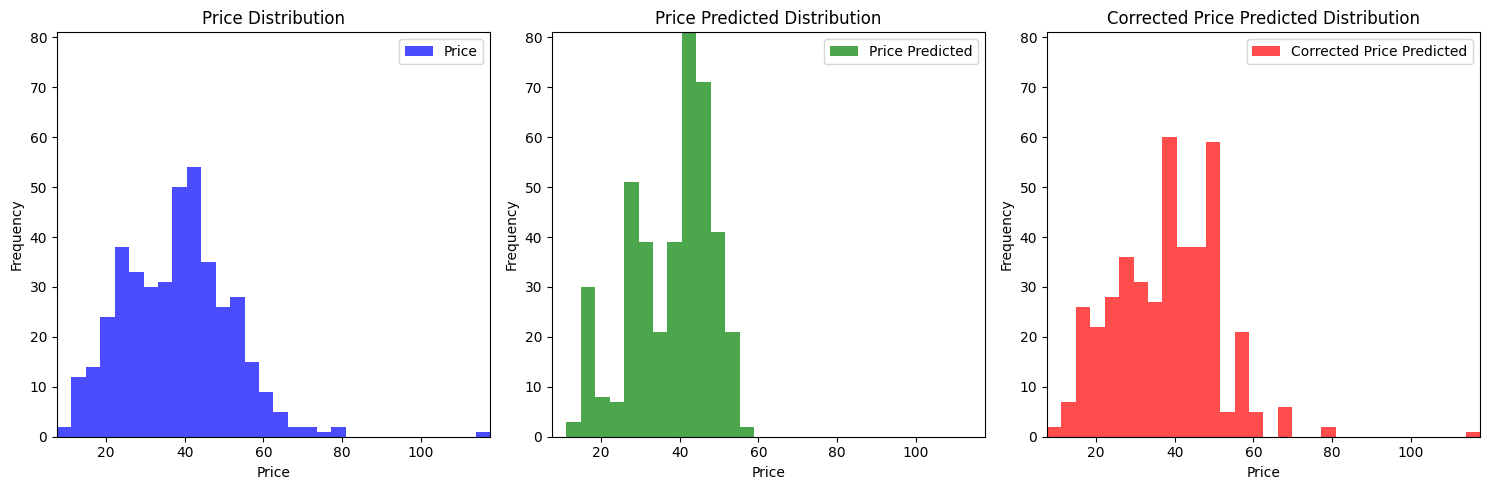

In [10]:
%matplotlib inline
plot_histograms([(df["X6"], "Price", "blue"), (price_predicted, "Price Predicted", "green"), (corrected_price, "Corrected Price Predicted", "red")], xlabel="Price")

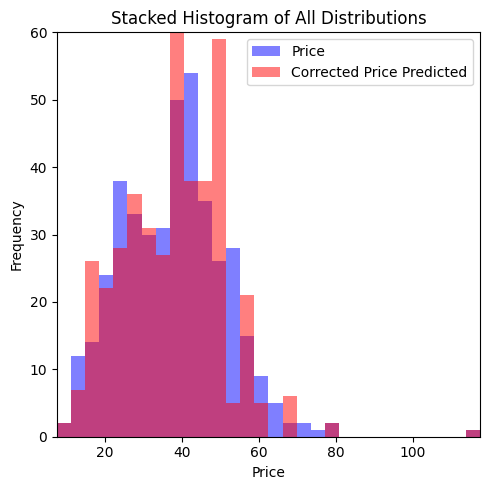

In [11]:
%matplotlib inline
plot_histograms([(df["X6"], "Price", "blue"), (corrected_price, "Corrected Price Predicted", "red")], xlabel="Price", stack=True)

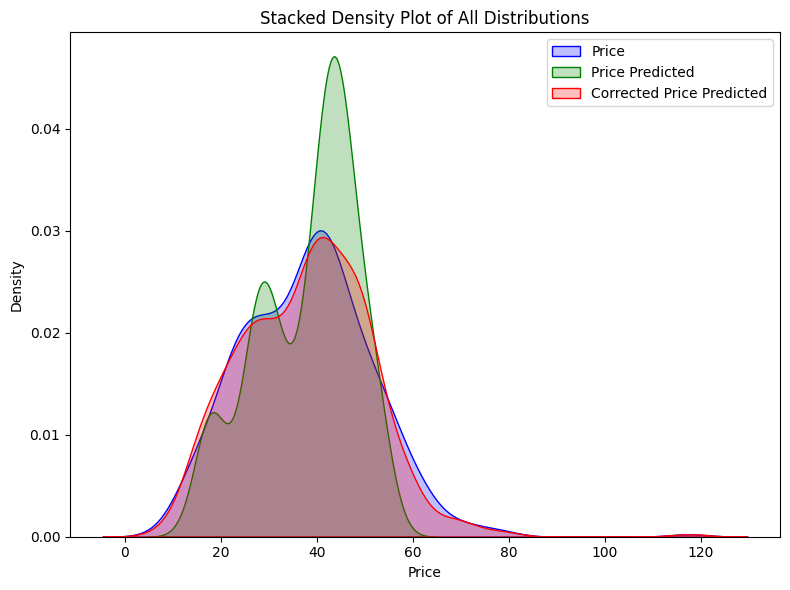

In [12]:
%matplotlib inline
plot_densities([(df["X6"], "Price", "blue"), (price_predicted, "Price Predicted", "green"), (corrected_price, "Corrected Price Predicted", "red")], xlabel="Price", stack=True, figsize_per_plot=(8, 6))

In [13]:
distributions = fit_distributions(df)

Processing column: X1
Processing column: X2
Processing column: X3
Processing column: X4
Processing column: X5
Processing column: X6


In [14]:
get_distribution_statements(distributions, df)

['Column "X1": distribution = gamma, alpha = 3.484, theta = 6.489, range = 0.0 to 43.8',
 'Column "X2": distribution = lognorm, mean = 6.367, deviation = 1.145, range = 23.383 to 6488.021',
 'Column "X3": distribution = gaussian, mean = 4.094, deviation = 2.942, range = 0 to 10 (with only whole numbers allowed)',
 'Column "X4": distribution = gaussian, mean = 24.969, deviation = 0.012, range = 24.932 to 25.015',
 'Column "X5": distribution = gaussian, mean = 121.533, deviation = 0.015, range = 121.474 to 121.566',
 'Column "X6": distribution = gaussian, mean = 37.98, deviation = 13.59, range = 7.6 to 117.5']

In [15]:
get_correlation_statements(correlation_matrix)

['Columns X2 and X3 (r = -0.69)',
 'Columns X2 and X4 (r = -0.43)',
 'Columns X2 and X5 (r = -0.47)',
 'Columns X3 and X4 (r = 0.43)',
 'Columns X3 and X5 (r = 0.41)',
 'Columns X4 and X5 (r = 0.26)']

In [16]:
# Suppose 'df' is your original DataFrame, and you want to drop the 'X6 price' column:
df_preprocessed = auto_preprocess_bn(df.drop(['X6'], axis=1), discrete_threshold=11)

# Fit the Bayesian network using bnlearn with the preprocessed DataFrame
model = bn.structure_learning.fit(df_preprocessed, methodtype='hc', scoretype='bic')
print(model['model_edges'])

[bnlearn] >Computing best DAG using [hc]
[bnlearn] >Set scoring type at [bic]
[bnlearn] >Compute structure scores for model comparison (higher is better).
[('X2', 'X1'), ('X3', 'X5'), ('X5', 'X2'), ('X5', 'X4')]


In [34]:
print(get_llm_generation_prompt(df, correlation_matrix=correlation_matrix, include_bn=True, enforce_positive_nums=True, discrete_threshold=12))

Generate a table with 6 columns and 414 rows with the following properties:

Column "X1": distribution = gamma, alpha = 3.484, theta = 6.489, range = 0.0 to 43.8
Column "X2": distribution = lognorm, mean = 6.367, deviation = 1.145, range = 23.383 to 6488.021
Column "X3": distribution = gaussian, mean = 4.094, deviation = 2.942, range = 0 to 10 (with only whole numbers allowed)
Column "X4": distribution = gaussian, mean = 24.969, deviation = 0.012, range = 24.932 to 25.015
Column "X5": distribution = gaussian, mean = 121.533, deviation = 0.015, range = 121.474 to 121.566
Column "X6": distribution = gaussian, mean = 37.98, deviation = 13.59, range = 7.6 to 117.5

With correlations:
Columns X2 and X3 (r = -0.69)
Columns X2 and X4 (r = -0.43)
Columns X2 and X5 (r = -0.47)
Columns X3 and X4 (r = 0.43)
Columns X3 and X5 (r = 0.41)
Columns X4 and X5 (r = 0.26)

With Bayesian Network structure:
X2 -> X6
X2 -> X1
X3 -> X5
X5 -> X2
X5 -> X4

All numbers in the table must be positive. Re-check th